<a href="https://colab.research.google.com/github/ugnet/Faster-RCNN/blob/main/FINAL_Faster_RCNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import csv
from skimage.io import imread_collection
import os
from csv import reader
import pandas as pd
import copy
import math

NOT_FOUND = "not_found"
CLASS_BEE = "/m/01h3n"
CLASS_FRUIT = "/m/02xwb"
CLASS_SEAFOOD = "/m/06nwz"
label_types = [CLASS_BEE, CLASS_FRUIT, CLASS_SEAFOOD]

#csv file paths
test_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/test-annotations-bbox.csv'
train_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv'
validate_csv_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/csv_folder/validation-annotations-bbox.csv'

TEST_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee"
TEST_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Fruit"
TEST_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Seafood"

TRAIN_BEE_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Bee"
TRAIN_FRUIT_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Fruit"
TRAIN_SEAFOOD_IMAGES = "/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/train/Seafood"

test_image_paths = [TEST_BEE_IMAGES, TEST_FRUIT_IMAGES, TEST_SEAFOOD_IMAGES]
train_image_paths = [TRAIN_BEE_IMAGES, TRAIN_FRUIT_IMAGES, TRAIN_SEAFOOD_IMAGES]

TEST_PURPOSE = "test"
TRAIN_PURPOSE = "train"

root_path = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee'

#your path 
bee_images_dir = '/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/*.jpg'
bee_images = imread_collection(bee_images_dir)

ISIZE = (800, 800)

#Imagenet statistics
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

## Anchor Box Specs
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:

def normalize(im):
    #im = im.astype(np.float32)/255.
    im = im/255.
    """Normalizes images with Imagenet stats."""
    return (im - imagenet_stats[0])/imagenet_stats[1] 

#function for vizualizing feature maps
def vizualize_feature_maps(feature_map, r):
  imgArray = feature_map.data.cpu().numpy().squeeze(0)
  fig=plt.figure(figsize=(12, 4))
  figNo=1
  for i in range(r):
    fig.add_subplot(1, r, figNo)
    plt.imshow(imgArray[i],  cmap='gray')
    figNo+=1
  plt.show()

#how to update boxes?
class MyDataset(object):
  def __init__(self):
    self.list_of_items = []
    #cia sitam metode turetu buti uzloadinami duomenys

  def __getitem__(self, index):
    item = self.list_of_items[index]
    img_path = item.path
    img = Image.open(img_path).convert("RGB")
    img = img.resize(ISIZE)
    img = np.array(img)
    img = normalize(img)
    img = img.transpose(2,0,1)
    img = torch.as_tensor(img, dtype=torch.float32)
    img = img.unsqueeze(0)

    # img = Image.open(img_path).convert("RGB")
    # img = img.resize(ISIZE)
    # img = np.array(img)
    # img = normalize(img)
    # img = img.transpose(2,0,1)
    # img = torch.as_tensor(img, dtype=torch.float32)

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(item.box_coordinates, dtype=torch.float32)
    # there is only one class
    # labels = torch.as_tensor(item.labels, dtype=torch.int64)
    # image_id = torch.tensor([item.id])

    # target = {}
    # target["boxes"] = boxes
    # target["labels"] = labels
    # target["image_id"] = image_id
    #target["path"] = item.path

    item_data = {'image': img, 'boxes': boxes, 'labels': item.labels}

    #permute
    #sample['img'] = sample['img'].permute(2, 0, 1)

    return item_data

  def getItemById(self, image_name):
    if ( len(self.list_of_items) == 0):
      return NOT_FOUND
    for item in self.list_of_items:
      if (item.id == image_name):
        return item
    return NOT_FOUND

  def __len__(self):
    return len(self.list_of_items)

  def addItem(self, item):
    self.list_of_items = np.append(self.list_of_items, item)

  def addBoxToItem(self, id, coordinate, label):
    item = self.getItemById(id)
    item.addBox(coordinate, label)

class Item(object):
  def __init__(self, id, name, path):
    super(Item).__init__()
    self.id = id
    self.name = name
    self.path = path
    self.labels = []
    self.box_coordinates = []

  def getBoxes(self):
    return self.box_coordinates

  def addBox(self, coordonates, label):
    self.box_coordinates.append(coordonates)
    self.labels.append(label)

def getImageFileNamesFromPath(directory):
  image_full_file_paths = []
  image_file_names = []

#problema cia su path
#NEGRAZINA image_full_file_paths!! BET IR NENAUDOJAM
  for path in os.listdir(directory):
      full_path = os.path.join(directory, path)
      file_name = os.path.splitext(path)[0]
      image_file_names = np.append(image_file_names, file_name)
      if os.path.isfile(path):
        image_full_file_paths = np.append(image_full_file_paths, full_path)

  return [image_full_file_paths, image_file_names]

#paduodame atrinktas csv failo eilutes turincias tik bbox'us mus dominancioms klasems
def createDataset(purpose, csv_rows):
  dataset = MyDataset()
  for row in csv_rows:
    id = row[0] #also id
    img_name = id + ".jpg"
    label = row[2]
    labels = []
    labels.append(row[2])
    image_path = getRootPath(label, purpose) + '/' + img_name
    # if (item_class == CLASS_BEE):
    #   image_path = root_path + img_name
    img = cv2.imread(image_path)
      #print(img)  #none 
    height, width = img.shape[:2]
    coordinate = [row[4]*800, row[6]*800, row[5]*800, row[7]*800]
    box_coordinates = []
    box_coordinates.append(coordinate)

    if (dataset.getItemById(id) == NOT_FOUND):
      #print("PRIDEJOOM")
      item = Item(id, img_name, image_path)
      item.addBox(coordinate, label)
      dataset.addItem(item)
      continue
    else:
      #print("JAU TUREJO")
      dataset.addBoxToItem(id, coordinate, label)

  return dataset

#is sio metodo gaunamas rows paduadame kurdami dataseta
def filterCsvRows(imageDirPaths, csv_file):
  imageFileNames = []
  for path in imageDirPaths:
    full, notfull = getImageFileNamesFromPath(path)
    imageFileNames = np.concatenate((imageFileNames, notfull))
  filteredRows = csv_file[(csv_file.LabelName.isin(label_types)) & (csv_file.ImageID.isin(imageFileNames))]
  filteredRows = filteredRows.values
  return filteredRows;

def getRootPath(class_name, purpose):
  if (class_name == CLASS_BEE and purpose == TEST_PURPOSE):
    return TEST_BEE_IMAGES
  elif (class_name == CLASS_BEE and purpose == TRAIN_PURPOSE):
    return TRAIN_BEE_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TEST_PURPOSE):
    return TEST_FRUIT_IMAGES
  elif (class_name == CLASS_FRUIT and purpose == TRAIN_PURPOSE):
    return TRAIN_FRUIT_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TEST_PURPOSE):
    return TEST_SEAFOOD_IMAGES
  elif (class_name == CLASS_SEAFOOD and purpose == TRAIN_PURPOSE):
    return TRAIN_SEAFOOD_IMAGES
  else:
    return NOT_FOUND



In [144]:
def get_image(path):
  return cv2.imread(path)

def display_image(image):
  img_cvt=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)
   
def show_corner_bbs(im, bbs):
    #im = np.asarray(im).astype(int).transpose(1,2,0)
    im = np.asarray(im).transpose(1,2,0)
    im = unnormalize(im)
    plt.imshow(im)
    for bb in bbs:
        plt.gca().add_patch(create_corner_rect(bb))  

def unnormalize(im):
    im = im.astype(np.float32)
    """Normalizes images with Imagenet stats."""
    im = (im *imagenet_stats[1] +  imagenet_stats[0])*255.
    im = im.astype(np.int)
    return im

class RPN(nn.Module):
    
    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()   
        self.mid_channels = mid_channels
        self.in_channels = in_channels # depends on the output feature map. in vgg 16 it is equal to 512
        self.n_anchor = n_anchor # Number of anchors at each location
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) 
        
        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
        
    def forward(self, k):
        bat_num = 1
        x = self.conv1(k)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        objectness_score = pred_cls_scores.view(bat_num, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores  = pred_cls_scores.view(bat_num, -1, 2)
        
        return pred_anchor_locs, pred_cls_scores, objectness_score

class DetectionNetwork(nn.Module):
    def __init__(self):
        super(DetectionNetwork, self).__init__()
        self.roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]) #AR GALIMA TURETI SEQUENTIAL NETWORKA VIDUJE NN>MODULE NETWORKO????
        self.cls_loc = nn.Linear(4096, 21 * 4) # (VOC 20 classes + 1 background. Each will have 4 co-ordinates)
        self.score = nn.Linear(4096, 21) # (VOC 20 classes + 1 background)

        self.cls_loc.weight.data.normal_(0, 0.01)
        self.cls_loc.bias.data.zero_()

    def forward(self, k):
        k = self.roi_head_classifier(k)
        roi_cls_loc = self.cls_loc(k)
        roi_cls_score = self.score(k)

        return roi_cls_loc, roi_cls_score

def DRLoss(logits, targets):
  margin = 0.5
  pos_lambda = 1
  neg_lambda = 0.1/math.log(3.5)
  L = 6.
  tau = 4.

  num_classes = logits.shape[1]
  dtype = targets.dtype
  device = targets.device
  class_range = torch.arange(1, num_classes + 1, dtype=dtype, device=device).unsqueeze(0)
  t = targets.unsqueeze(1)
  pos_ind = (t == class_range)
  neg_ind = (t != class_range) * (t >= 0)
  pos_prob = logits[pos_ind].sigmoid()
  neg_prob = logits[neg_ind].sigmoid()
  neg_q = F.softmax(neg_prob/neg_lambda, dim=0)
  neg_dist = torch.sum(neg_q * neg_prob)
  if pos_prob.numel() > 0:
      pos_q = F.softmax(-pos_prob/pos_lambda, dim=0)
      pos_dist = torch.sum(pos_q * pos_prob)
      loss = tau*torch.log(1.+torch.exp(L*(neg_dist - pos_dist+margin)))/L
  else:
      loss = tau*torch.log(1.+torch.exp(L*(neg_dist - 1. + margin)))/L
  return loss





        

In [140]:
#Main

def prepareData(purpose):
  if (purpose == TEST_PURPOSE):
    #csffile that we will read
    csv_file = pd.read_csv(test_csv_path)
    rows = filterCsvRows(test_image_paths, csv_file)
    dataset = createDataset(TEST_PURPOSE, rows)
    return dataset
  elif (purpose == TRAIN_PURPOSE):
    #csffile that we will read
    csv_file = pd.read_csv(train_csv_path)
    rows = filterCsvRows(train_image_paths, csv_file)
    dataset = createDataset(TRAIN_PURPOSE, rows)
    return dataset
  else:
    return NOT_FOUND

#resize images
#display image with its boxes
def train_model(vgg_req_features, optimizer, epochs, RPNmodel, data_loader, DetectionModel, rpn_lambda=10):
  for epoch in range(epochs):
    RPNmodel.train()
    DetectionModel.train()
    total = 0
    sum_loss = 0
    sum_loss_cls = 0
    sum_loss_loc = 0

    loc_normalize_mean = (0., 0., 0., 0.)
    loc_normalize_std = (0.1, 0.1, 0.2, 0.2)

    index = 0 
    # print("Epoch ", epoch)
    # print("i  ", i)
    
    for item in data_loader:
      num_batch =  1 #len(item) #grazina 3 bet gal turetu buti 1?
      # print(num_batch)
      image_tensor = item['image']
      bboxes = item['boxes']
      bboxes = np.asarray(bboxes)
      labels = item['labels']
      # print('BBOXES: ', bboxes[0])
      #nuimam viena dimensija
      image_tensor=image_tensor.squeeze(0)
      #padarom feature_mapsus
      feature_maps = vgg_req_features(image_tensor)
      # print("##############   feature map shape: ", feature_maps.shape) 
      X_FM, Y_FM = feature_maps.shape[2:]
      #print("##############  X_FM, Y_FM: ",  X_FM, Y_FM )


      anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(item, X_FM, Y_FM)

      #svarbiausia vieta
      pred_anchor_locs, pred_cls_scores, objectness_score = RPNmodel(feature_maps)
      region_proposals = NMS(pred_anchor_locs, objectness_score, anchors)
      gt_roi_locs, gt_roi_labels, sample_rois = proposalTargets(region_proposals, bboxes, labels)
      k = ROIPooling(sample_rois, feature_maps)
      roi_cls_loc, roi_cls_score = DetectionModel(k)

      # print("PERUZLTATAS 1: ", roi_cls_loc)
      # print("PERUZLTATAS 2: ", roi_cls_score)

      # # We are assuming that batch size is 1.
      # scale = 1
      # roi_cls_loc = roi_cls_loc.detach().numpy()
      # roi_score = roi_cls_score.detach().numpy()
      # roi = sample_rois / scale

      # # Convert predictions to bounding boxes in image coordinates.
      # # Bounding boxes are scaled to the scale of the input images.
      # cls = 2 #TOTALNUMBER OF CLASSES INCUDING BACKGROUND!!!!!
      # mean = torch.Tensor(loc_normalize_mean).cuda().repeat(cls)
      # std = torch.Tensor(loc_normalize_std).cuda().repeat(cls)

      # roi_cls_loc = (roi_cls_loc * std + mean)
      # roi_cls_loc = roi_cls_loc.view(-1, cls, 4)
      # roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
      # cls_bbox = loc2bbox(tonumpy(roi).reshape((-1, 4)),
      #                     tonumpy(roi_cls_loc).reshape((-1, 4)))
      # cls_bbox = totensor(cls_bbox)
      # cls_bbox = cls_bbox.view(-1, cls * 4)
      # # clip bounding box
      # cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
      # cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

      # prob = (F.softmax(totensor(roi_cls_score), dim=1))

      # bbox, label, score = suppress(cls_bbox, prob, cls)
      
      # print('#################################################')
      # print(region_proposals)
      # print("aaa", region_proposals.shape)
      # print('#################################################')
      # print('pred_anchor_locs', pred_anchor_locs)# 1, 22500, 4
      # print('pred_cls_scores', pred_cls_scores)#22500, 2
      # print('objectness_score', objectness_score)# 22500, 4

      #LOSS F-JOS

      #RPN loss
      rpn_loc_all = pred_anchor_locs.view(1,-1,4).squeeze(0)
      rpn_score_all = pred_cls_scores.view(1,-1,2).squeeze(0)
      #print(rpn_loc_all.shape, rpn_score_all.shape)
      gt_rpn_loc_all = torch.from_numpy(anchor_locations_all_merge.astype(np.float32)).view(1,-1,4).squeeze(0)
      gt_rpn_score_all = torch.from_numpy(anchor_labels_all_merge.astype(np.float32)).view(1,-1).squeeze(0)

      #print(rpn_score_all.shape, gt_rpn_score_all.shape)
      rpn_cls_loss_all = F.cross_entropy(rpn_score_all, gt_rpn_score_all.long(), ignore_index = -1)
      #print(rpn_cls_loss_all)
      
      pos_all = gt_rpn_score_all > 0
      mask_all = pos_all.unsqueeze(1).expand_as(rpn_loc_all)
      #print(pos_all.shape, pos_all.unsqueeze(1).shape, rpn_loc_all.shape,  pos_all.unsqueeze(1).expand_as(rpn_loc_all).shape) 
      num_valid_loc_all = 0
      for i, j in enumerate(pos_all):
          if j.item() == True:
              num_valid_loc_all += 1
      #print (num_valid_loc_all)              
      
      mask_loc_preds_all = rpn_loc_all[mask_all].view(-1, 4)
      #print(mask_loc_preds_all.shape)
      mask_loc_targets_all = gt_rpn_loc_all[mask_all].view(-1, 4)
      #print(mask_loc_preds_all.dtype, mask_loc_targets_all.dtype,gt_rpn_loc_all.dtype ) 

      x_all = torch.abs(mask_loc_targets_all - mask_loc_preds_all)
      rpn_loc_loss_all = ((x_all < 1).float() * 0.5 * x_all**2) + ((x_all >= 1).float() * (x_all-0.5))
      #print(rpn_loc_loss_all.sum())            
      
      N_reg_all = (gt_rpn_score_all >0).float().sum()
      rpn_loc_loss_all = rpn_loc_loss_all.sum() / N_reg_all
      rpn_loss_all = rpn_cls_loss_all + (rpn_lambda * rpn_loc_loss_all)
      #print(rpn_cls_loss_all, rpn_loc_loss_all, rpn_loss_all)  

      #Fast R-CNN loss
      #Converting ground truth to torch variable
      gt_roi_loc = torch.from_numpy(gt_roi_locs)
      gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
      # print(gt_roi_loc.shape, gt_roi_label.shape)
      #Out:
      #torch.Size([128, 4]) torch.Size([128])

      # classification loss
      roi_clss_loss = DRLoss(roi_cls_score, gt_roi_label)
      # roi_clss_loss = F.cross_entropy(roi_cls_score, gt_roi_label, ignore_index=-1)
      print("!!!!!!!!!!!!!", roi_clss_loss)
      #Out:
      #Variable containing:
      #  3.0458
      # [torch.FloatTensor of size 1]

      n_sample = roi_cls_loc.shape[0]
      roi_loc = roi_cls_loc.view(n_sample, -1, 4)
      # print(roi_loc.shape)
      #Out:
      #torch.Size([128, 21, 4])
      roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
      print('roi_loc: ',roi_loc)
      #Out:
      #torch.Size([128, 4])
      # roi_loc_loss = REGLoss(roi_loc, gt_roi_loc)#NECEIKIA NERA REGLOSS!!!!
      # print(roi_loc_loss)
      #Out:
      #Variable containing:
      #  0.1895
      # [torch.FloatTensor of size 1]

      optimizer.zero_grad()
      rpn_loss_all.backward()
      optimizer.step()
      
      total += num_batch
      sum_loss += rpn_loss_all.item()
      sum_loss_cls += rpn_cls_loss_all.item()
      sum_loss_loc += (rpn_lambda * rpn_loc_loss_all).item()
      print("aa")
      index = index+1
      if (index>=2):
        break
    
    train_loss = sum_loss/total
    train_loss_cls = sum_loss_cls/total
    train_loss_loc = sum_loss_loc/total
    torch.save(RPNmodel.state_dict(), '/content/drive/MyDrive/GMM/rpn_model_%s.pth'%epoch)
    torch.save(DetectionModel.state_dict(), '/content/drive/MyDrive/GMM/detection_model_%s.pth'%epoch)
    print("train_loss %.3f cls_loss %.3f loc_loss %.3f" % (train_loss, train_loss_cls, train_loss_loc))

  torch.save(RPNmodel.state_dict(), '/content/drive/MyDrive/GMM/rpn_model.pt')
  torch.save(DetectionModel.state_dict(), '/content/drive/MyDrive/GMM/detection_model.pt')

  return RPNmodel, DetectionModel

  def suppress(raw_cls_bbox, raw_prob, num_of_classes):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, num_of_classes):
            cls_bbox_l = raw_cls_bbox.reshape((-1, num_of_classes, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            keep = nms(cls_bbox_l, prob_l,self.nms_thresh)
            # import ipdb;ipdb.set_trace()
            # keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep].cpu().numpy())
            # The labels are in [0, num_of_classes - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep].cpu().numpy())
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score

def totensor(data, cuda=True):
    if isinstance(data, np.ndarray):
        tensor = t.from_numpy(data)
    if isinstance(data, t.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor

def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, t.Tensor):
        return data.detach().cpu().numpy()


In [123]:
def validate(model, data_loader, vgg_req_features, detection_model):
    items = [next(iter(data_loader))]
    print(items)

    itm = items
    img  = items[0]["image"]
    bbox = items[0]["boxes"]
    labels = items[0]["labels"]
    print("bbox: ", bbox)
    print("labels: ", labels)
    # print(img.shape)
    img = img.squeeze(0)
    img = img.squeeze(0)
    X_IMG, Y_IMG = img.shape[1:]
    
    img_all = [item['image'] for item in items]
    bbox_all = [item['boxes'] for item in items]
    labels_all = [item['labels'] for item in items]

    # show_corner_bbs(img_all[1], bbox_all[1])
    print( bbox_all[0])
    img_all[0] = img_all[0].squeeze(0)
    img_all[0] = img_all[0].squeeze(0)
    show_corner_bbs(img_all[0], bbox_all[0][0])
    
    num_batch =  1
    
    # imgs_torch_all = torch.stack([item for item in images])
    # if is_cuda:
    #     imgs_torch_all = imgs_torch_all.cuda()   
    # k = imgs_torch_all.clone()
    img = img.unsqueeze(0)
    feature_maps = vgg_req_features(img)
    #print("##############   feature map shape: ", k.shape) 
    X_FM, Y_FM = feature_maps.shape[2:]
    anchor_locations_all_merge, anchor_labels_all_merge, anchors = bbox_generation(items[0], X_FM, Y_FM)
    pred_anchor_locs, pred_cls_scores, objectness_score = model(feature_maps)
    region_proposals = NMS(pred_anchor_locs, objectness_score, anchors)
    gt_roi_locs, gt_roi_labels, sample_rois = proposalTargets(region_proposals, bbox, labels)
    k = ROIPooling(sample_rois, feature_maps)
    roi_cls_loc, roi_cls_score = detection_model(k)
    # print("pred_anchor_locs: ", pred_anchor_locs)
    # print("pred_cls_scores: ", pred_cls_scores)
    # print("objectness_score: ", objectness_score)
    # print(pred_anchor_locs.shape, pred_cls_scores.shape, objectness_score.shape)
    # print(objectness_score[0,1])
    max_score = pred_cls_scores.argmax(1)
    max_ = objectness_score.argmax(1)
    print(max_score)
    # print(max_)
    top_bbox = []
    for ind, item in enumerate(max_):
        # print(item.item())
        # print(pred_anchor_locs[ind,item.item()])
        roi = pred_bbox_to_xywh(pred_anchor_locs[ind], anchors)
        print (roi.shape)
        # print("index: %s bbox: %s "%(ind, roi[item]))
        top_bbox.append([roi[item]])
    #plot_imges_with_bboxes(images, bbox_all)   
    plot_imges_with_bboxes(img, top_bbox)

def plot_imges_with_bboxes(imgs, bboxes, col=4):
    num_imgs = len(imgs)
    row = int(np.ceil(float(len(imgs))/col).item())
    # print("row: %s"%row)
    # print("imgs: ", num_imgs)
    fig = plt.figure(figsize=(2*col,2*row))
    fig.tight_layout()
    for i in range(row):
        for j in range(col):
            ind = i*col + j
            if ind < num_imgs:
                img = imgs[ind]
                bbs = bboxes[ind]
                # print("JABJAJSGV", img.shape)
                img = np.asarray(img).transpose(1,2,0)
                img = unnormalize(img)
                ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
                ax.imshow(img) 
                for bb in bbs:
                    plt.gca().add_patch(create_corner_rect(bb))
            #ax.text(3, 6, ind, fontdict={'weight': 'bold', 'size': 16}, color="y" )
    fig.suptitle("Images")

def pred_bbox_to_xywh(bbox, anchors):
    # print("bbox: ", bbox.shape)
    # print("anchors: ", anchors.shape)
    anc_height = anchors[:, 2] - anchors[:, 0]
    anc_width = anchors[:, 3] - anchors[:, 1]
    anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
    anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

    bbox_numpy = bbox.detach().cpu().data.numpy()
    dy = bbox_numpy[:, 0::4]
    dx = bbox_numpy[:, 1::4]
    dh = bbox_numpy[:, 2::4]
    dw = bbox_numpy[:, 3::4]
    ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    roi = np.zeros(bbox_numpy.shape, dtype=h.dtype)
    roi[:, 0::4] = ctr_y - 0.5 * h
    roi[:, 1::4] = ctr_x - 0.5 * w
    roi[:, 2::4] = ctr_y + 0.5 * h
    roi[:, 3::4] = ctr_x + 0.5 * w

    return roi

In [10]:
#Generating proposals to feed Fast R-CNN network
def NMS(pred_anchor_locs, objectness_score, ancor_boxes): #non-maximum supression
  nms_thresh = 0.7
  n_train_pre_nms = 12000
  n_train_post_nms = 2000
  n_test_pre_nms = 6000
  n_test_post_nms = 300
  min_size = 16

  anc_height = ancor_boxes[:, 2] - ancor_boxes[:, 0]
  anc_width = ancor_boxes[:, 3] - ancor_boxes[:, 1]
  anc_ctr_y = ancor_boxes[:, 0] + 0.5* anc_height
  anc_ctr_x = ancor_boxes[:, 1] + 0.5* anc_width
  # print(anc_ctr_x.shape) #(22500,)

  # pred_anchor_locs, pred_cls_scores, objectness_score
  pred_ancor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
  objectness_score_numpy = objectness_score[0].cpu().data.numpy()
  dy = pred_ancor_locs_numpy[:, 0::4]
  dx = pred_ancor_locs_numpy[:, 1::4]
  dh = pred_ancor_locs_numpy[:, 2::4]
  dw = pred_ancor_locs_numpy[:, 3::4]
  # print(dy.shape) #(22500, 1)

  ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
  ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
  h = np.exp(dh) * anc_height[:, np.newaxis]
  w = np.exp(dw) * anc_width[:, np.newaxis]
  # print(w.shape) #(22500, 1)

  roi = np.zeros(pred_ancor_locs_numpy.shape)# nepridejau data type
  roi[:, 0::4] = ctr_y - 0.5 * h
  roi[:, 1::4] = ctr_x - 0.5 * w
  roi[:, 2::4] = ctr_y + 0.5 * h
  roi[:, 3::4] = ctr_y + 0.5 * w
  # print(roi.shape)

  #clip predicted boxes to the image
  img_size = (800, 800)
  roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
  roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
  # print(roi.shape, np.max(roi), np.min(roi))

  hs = roi[:, 2] - roi[:, 0]
  ws = roi[:, 3] - roi[:, 1]
  keep = np.where((hs >= min_size) & (ws >= min_size))[0]
  roi = roi[keep, :]
  score = objectness_score_numpy[keep]
  # print()

  order = score.ravel().argsort()[::-1]
  # print(order.shape)

  order = order[:n_train_pre_nms]
  roi = roi[order, :]
  # print(order.shape, roi.shape)

  #take all theroi boxes
  y1 = roi[:, 0]
  x1 = roi[:, 1]
  y2 = roi[:, 2]
  x2 = roi[:, 3]

  #find the areas of all the boxes
  areas = (x2 - x1 + 1) * (y2 - y1 + 1)

  order = order.argsort()[::-1]
  keep = []
  while (order.size > 0):
      i = order[0]
      keep.append(i)
      xx1 = np.maximum(x1[i], x1[order[1:]])
      yy1 = np.maximum(y1[i], y1[order[1:]])
      xx2 = np.minimum(x2[i], x2[order[1:]])
      yy2 = np.minimum(y2[i], y2[order[1:]])
      w = np.maximum(0.0, xx2 - xx1 + 1)
      h = np.maximum(0.0, yy2 - yy1 + 1)
      inter = w * h
      ovr = inter / (areas[i] + areas[order[1:]] - inter)
      inds = np.where(ovr <= nms_thresh)[0]
      order = order[inds + 1]
  keep = keep[:n_train_post_nms] # while training/testing , use accordingly
  roi = roi[keep] # the final region proposals

  return roi

  
def proposalTargets(roi, bboxes, labels):
  # print("LABELS: ", labels)

  labels = np.asarray([1, 2], dtype=np.int8)

  n_sample = 128
  pos_ratio = 0.25
  pos_iou_thresh = 0.5
  neg_iou_thresh_hi = 0.5
  neg_iou_thresh_lo = 0.0
  pos_roi_per_image = 32

  # print("ROI: ",roi.shape)
  # print(roi)

  # Find the iou of each ground truth object with the region proposals, 
  # We will use the same code we have used in Anchor boxes to calculate the ious
  #skaiciuojam validziu ancor boxes iou
  # ious_all = []
  # for bbox in bboxes:
  # print("bboxes: ", bboxes)
  bbox = bboxes[0]
  ious = np.empty((len(roi), 2), dtype=np.float32)
  ious.fill(0)
  for num1, i in enumerate(roi):
      # print("roi num1: ",num1)
      ya1, xa1, ya2, xa2 = i  
      anchor_area = (ya2 - ya1) * (xa2 - xa1)
      for num2, j in enumerate(bboxes[0]):
          # print("bbox num2: ",num2)
          yb1, xb1, yb2, xb2 = j
          box_area = (yb2- yb1) * (xb2 - xb1)
          inter_x1 = max([xb1, xa1])
          inter_y1 = max([yb1, ya1])
          inter_x2 = min([xb2, xa2])
          inter_y2 = min([yb2, ya2])
          if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
              iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
              iou = iter_area / (anchor_area+ box_area - iter_area)            
          else:
              iou = 0.
          # print("iou: ", iou)
          if (num2 > 1): #WORKAROUND KAI DAUGIAU BOXU VIENAME IMAGE, PASKUI ISTAISYTI!!
            break
          ious[num1, num2] = iou#<<<<<<<<<
  # print("IOUS SHAPE", ious.shape)
    # ious_all.append(ious)
  # print("ALL IOUS: ", ious)
  

  # Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
  # print("IOU: HAHAHAH ", iou)
  gt_assignment = ious.argmax(axis=1)
  max_iou = ious.max(axis=1)
  # print("gt_assignment: ", gt_assignment)
  # print("max_iou: ", max_iou)

  # Assign the labels to each proposal
  gt_roi_label = labels[gt_assignment]
  # print("gt_roi_label", gt_roi_label)

  #Note: Incase if u have not taken the background object as 0, add +1 to all the labels.
  # Select the foreground rois as per the pos_iou_thesh. 
  pos_index = np.where(max_iou >= pos_iou_thresh)[0]
  pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
  if pos_index.size > 0:
      pos_index = np.random.choice(
          pos_index, size=pos_roi_per_this_image, replace=False)
  # print(pos_roi_per_this_image)
  # print(pos_index)

  #Similarly we do for negitive (background) region proposals also
  neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
  neg_roi_per_this_image = n_sample - pos_roi_per_this_image
  neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                  neg_index.size))
  if  neg_index.size > 0 :
      neg_index = np.random.choice(
          neg_index, size=neg_roi_per_this_image, replace=False)
  # print(neg_roi_per_this_image)
  # print(neg_index)

  # Now we gather positve samples index and negitive samples index, their respective labels and region proposals
  keep_index = np.append(pos_index, neg_index)
  gt_roi_labels = gt_roi_label[keep_index]
  gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
  sample_roi = roi[keep_index]
  # print("SAMPLE ROI", sample_roi.shape)

  bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
  # print(bbox_for_sampled_roi.shape)
  #Out
  #(128, 4)
  height = sample_roi[:, 2] - sample_roi[:, 0]
  width = sample_roi[:, 3] - sample_roi[:, 1]
  ctr_y = sample_roi[:, 0] + 0.5 * height
  ctr_x = sample_roi[:, 1] + 0.5 * width
  base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
  base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
  base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
  base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

  eps = np.finfo(height.dtype).eps
  height = np.maximum(height, eps)
  width = np.maximum(width, eps)
  dy = (base_ctr_y - ctr_y) / height
  dx = (base_ctr_x - ctr_x) / width
  dh = np.log(base_height / height)
  dw = np.log(base_width / width)
  gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
  # print(gt_roi_locs)

  return gt_roi_locs, gt_roi_labels, sample_roi


def ROIPooling(sample_rois, out_map):
  # Since sample_rois is a numpy array, we will convert into Pytorch Tensor. create an roi_indices tensor.
  rois = torch.from_numpy(sample_rois).float()
  roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
  roi_indices = torch.from_numpy(roi_indices).float()
  # print("CIA 1: ", rois.shape, roi_indices.shape)
  #Out:
  #torch.Size([128, 4]) torch.Size([128]) 

  # concat rois and roi_indices, so that we get the tensor with shape [N, 5] (index, x, y, h, w)
  indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
  xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
  indices_and_rois = xy_indices_and_rois.contiguous()
  # print("CIA 2: ", xy_indices_and_rois.shape)
  #Out:
  #torch.Size([128, 5])

  # Now we need to pass this array to the roi_pooling layer. We will briefly discuss the workings of it here. The sudo code is as follows
  size = (7, 7)
  adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])
  output = []
  rois = indices_and_rois.data.float()
  rois[:, 1:].mul_(1/16.0) # Subsampling ratio
  rois = rois.long()
  num_rois = rois.size(0)
  for i in range(num_rois):
      roi = rois[i]
      im_idx = roi[0]
      im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
      tmp = adaptive_max_pool(im)
      output.append(tmp[0])
  output = torch.cat(output, 0)
  
  #Out:
  # torch.Size([128, 512, 7, 7])
  # Reshape the tensor so that we can pass it through the feed forward layer.
  k = output.view(output.size(0), -1)
  # print(k.shape)
  #Out:
  # torch.Size([128, 25088]) 7*7*512 = 25088
  return k



In [11]:
def bbox_generation(items, X_FM, Y_FM):
    global ratios
    global anchor_scales
    num_batch = 1
    X_IMG, Y_IMG = 800, 800
    bbox_all = items["boxes"]#BLOGAIII ITEM MES NETURIM!!!!!!
    # print("BBOX ALL: ", bbox_all)
    labels_all = items['labels']
    # print("LABELS ALL: ", labels_all) 

    sub_sampling_x = int(X_IMG/X_FM)
    sub_sampling_y = int(Y_IMG/Y_FM)
    #print(X_IMG, Y_IMG, X_FM, Y_FM, sub_sampling_x,sub_sampling_y)
    anchor_base = np.zeros((len(ratios)*len(anchor_scales), 4), dtype=np.float32)

    ctr_x = np.arange(sub_sampling_x, (X_FM+1) * sub_sampling_x, sub_sampling_x)
    ctr_y = np.arange(sub_sampling_y, (Y_FM+1) * sub_sampling_y, sub_sampling_y)
    index = 0
    ctr = np.zeros((len(ctr_y)*len(ctr_y),2),dtype=np.float32)
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1 
            
    anchors = np.zeros((X_FM * Y_FM * 9, 4))
    index = 0
    for ctr_y, ctr_x in ctr:
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = sub_sampling_x * anchor_scales[j] * np.sqrt(ratios[i])
                w = sub_sampling_y * anchor_scales[j] * np.sqrt(1./ ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1

    index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= Y_IMG) &
        (anchors[:, 3] <= X_IMG)
    )[0]
    
    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    valid_anchors = anchors[index_inside]
    #print(valid_anchors[0]

    #skaiciuojam validziu ancor boxes iou
    ious_all = []
    for bx in bbox_all:
        # print("BOX", bx)
        ious = np.empty((len(label), bx.size()[0]), dtype=np.float32)
        ious.fill(0)
        for num1, i in enumerate(valid_anchors):
            ya1, xa1, ya2, xa2 = i  
            anchor_area = (ya2 - ya1) * (xa2 - xa1)
            for num2, j in enumerate(bx):
                yb1, xb1, yb2, xb2 = j
                box_area = (yb2- yb1) * (xb2 - xb1)
                inter_x1 = max([xb1, xa1])
                inter_y1 = max([yb1, ya1])
                inter_x2 = min([xb2, xa2])
                inter_y2 = min([yb2, ya2])
                if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                    iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                    iou = iter_area / (anchor_area+ box_area - iter_area)            
                else:
                    iou = 0.
                ious[num1, num2] = iou
        ious_all.append(ious)

    # print("IOUS ALL: (8490, num of objects)", ious_all)
        
        
    gt_argmax_ious_all = []
    gt_max_ious_all = []
    for ious_ in ious_all:
        gt_argmax_ious = ious_.argmax(axis=0)
        gt_max_ious = ious_[gt_argmax_ious, np.arange(ious_.shape[1])]
        gt_argmax_ious_all.append(gt_argmax_ious)
        gt_max_ious_all.append(gt_max_ious)
    #print(gt_argmax_ious_all)  
    #print(gt_max_ious_all)   
    argmax_ious_all = []
    max_ious_all = []
    for ious_ in ious_all:
        argmax_ious = ious_.argmax(axis=1)
        max_ious = ious_[np.arange(len(label)), argmax_ious]
        argmax_ious_all.append(argmax_ious)
        max_ious_all.append(max_ious)
    #print(argmax_ious_all)    
    #print(max_ious_all)  
    
    #what ancor box has max iou with the ground truth box
    gt_argmax_ious_all = []
    for gt_max_ious_, ious_ in zip(gt_max_ious_all, ious_all):
        gt_argmax_ious = np.where(ious_ == gt_max_ious_)[0]
        gt_argmax_ious_all.append(gt_argmax_ious)
    # print("hahahahahah: ", gt_argmax_ious_all)       

    pos_iou_threshold  = 0.7
    neg_iou_threshold = 0.3  
    
    label_all = []
    for n in range(num_batch):
        l = copy.deepcopy(label)
        l[max_ious_all[n] < neg_iou_threshold] = 0
        l[gt_argmax_ious_all[n]] = 1
        l[max_ious_all[n] >= pos_iou_threshold] = 1
        label_all.append(l)
    #print ("label_all 0 and 1: ", sum(label_all[0]), sum(label_all[1]))     
    
    pos_ratio = 0.5
    n_sample = 256
    n_pos = int(pos_ratio * n_sample)
    #print(n_pos)    
    for n in range(num_batch):
        #print(np.sum((label_all[n] == 1)))
        pos_index = np.where(label_all[n] == 1)[0]
        # print("pos_index!!!!!!!!!! ", pos_index)
        #print(pos_index)
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 1)))  

        n_neg = n_sample - np.sum(label_all[n] == 1)
        neg_index = np.where(label_all[n] == 0)[0]
        # print("neg_index!!!!!!!!!! ", neg_index)
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
            label_all[n][disable_index] = -1
        #print(np.sum((label_all[n] == 0)))   
        
        
    max_iou_bbox_all = []
    #print(bbox_all)
    for n in range(num_batch):
        max_iou_bbox_all.append(bbox_all[n][argmax_ious_all[n]])
    #print(max_iou_bbox_all[0].shape, max_iou_bbox_all[0].shape)    
    #Anchor box
    height = valid_anchors[:, 2] - valid_anchors[:, 0]
    width = valid_anchors[:, 3] - valid_anchors[:, 1]
    ctr_y = valid_anchors[:, 0] + 0.5 * height
    ctr_x = valid_anchors[:, 1] + 0.5 * width
    #Ground truth
    base_height_all = []
    base_width_all = []
    base_ctr_y_all = []
    base_ctr_x_all = []
    for n in range(num_batch):
        base_height = max_iou_bbox_all[n][:, 2] - max_iou_bbox_all[n][:, 0]
        base_width = max_iou_bbox_all[n][:, 3] - max_iou_bbox_all[n][:, 1]
        base_ctr_y = max_iou_bbox_all[n][:, 0] + 0.5 * base_height
        base_ctr_x = max_iou_bbox_all[n][:, 1] + 0.5 * base_width
        base_height_all.append(base_height)
        base_width_all.append(base_width)
        base_ctr_y_all.append(base_ctr_y)
        base_ctr_x_all.append(base_ctr_x)

    #print(width[2], base_width_all[0][2])        
        
    #Prevent devide by 0
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    #d_{} calculatrion
    anchor_locs_all = []
    for n in range(num_batch):
        dy = (base_ctr_y_all[n].numpy() - ctr_y) / height
        dx = (base_ctr_x_all[n].numpy() - ctr_x) / width
        dh = np.log(base_height_all[n].numpy()/ height)
        dw = np.log(base_width_all[n].numpy() / width)
        anchor_locs_all.append(np.vstack((dy, dx,dh, dw)).transpose())
    #print(anchor_locs_all[0][1], anchor_locs_all[0].shape)      
    anchor_labels_all = []
    for n in range(num_batch):
        anchor_labels = np.empty((len(anchors),), dtype=label_all[n].dtype)
        anchor_labels.fill(-1)
        anchor_labels[index_inside] = label_all[n]
        anchor_labels_all.append(anchor_labels)
    anchor_labels_all_merge = np.stack(anchor_labels_all, 0)    
    #print(sum(anchor_labels_all[0]==1), anchor_labels_all[0][0:11])
    #print(anchor_labels_all_merge.shape)
    #print(sum(anchor_labels_all_merge[0]==1))    
    
    anchor_locations_all = []
    for n in range(num_batch):
        anchor_locations = np.empty((len(anchors), anchors.shape[1]), dtype=anchor_locs_all[n].dtype)
        anchor_locations.fill(0)
        anchor_locations[index_inside, :] = anchor_locs_all[n]
        anchor_locations_all.append(anchor_locations)
    #print(anchor_locations_all[0].shape)   
    #print(type(anchor_locations_all[0]))
    anchor_locations_all_merge = np.stack(anchor_locations_all, 0)
    #print(anchor_locations_all_merge[0][0])
    #print(anchor_locations_all[0][1500])   


    # print('KA GRAZINA generate_bbox') 
    # print('anchor_locations_all_merge: ', anchor_locations_all_merge.shape) 
    # print('anchor_labels_all_merge: ', anchor_labels_all_merge.shape) 
    # print('anchors: ', anchors.shape) 
  
    return anchor_locations_all_merge, anchor_labels_all_merge, anchors

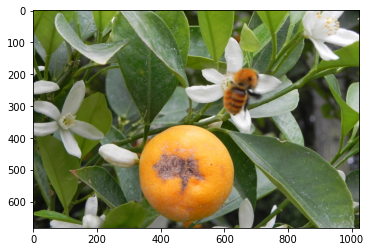

30
512


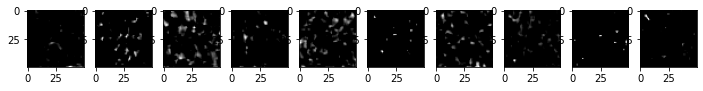

torch.Size([1, 512, 50, 50])


In [147]:
image = get_image('/content/drive/MyDrive/GMM/OIDv4_ToolKit/OID/Dataset/test/Bee/000e4e7ed48c932d.jpg')
display_image(image)
image_2_npArray = np.asarray(image)
image = torchvision.transforms.ToTensor()(image_2_npArray)
# add one more dimension
image = image.unsqueeze(0)
image = F.interpolate(image, 800)
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)
req_features = []
k = image.clone()
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features)) #30
print(out_channels) # 512

faster_rcnn_fe_extractor = nn.Sequential(*req_features)
feature_map = faster_rcnn_fe_extractor(image)
vizualize_feature_maps(feature_map, 10)
print(feature_map.size())

!!!!!!!!!!!!! tensor(2.1259, grad_fn=<DivBackward0>)
roi_loc:  tensor([[ 2.1127e-01, -5.2076e-01, -5.1387e-04,  3.4774e-01],
        [ 4.2244e-01, -2.0369e-01,  1.4630e-01,  6.3552e-01],
        [ 2.5406e-01, -1.9058e-01, -2.7791e-01,  4.0481e-01],
        [-2.9804e-02,  1.0823e-02,  7.4411e-02,  4.1989e-01],
        [ 9.2986e-02, -1.2759e-02, -1.0546e-01,  5.2093e-01],
        [ 4.0302e-01, -4.8413e-01, -1.3140e-01,  6.2923e-01],
        [ 1.4721e-01, -6.3753e-01,  9.2204e-03,  6.7333e-01],
        [ 2.0140e-01, -5.6733e-02,  8.9700e-02,  4.0507e-01],
        [ 4.2837e-01, -1.3603e-01, -5.6748e-02,  5.4990e-01],
        [ 5.4073e-01, -5.5560e-01,  2.3466e-01,  5.5504e-01],
        [ 5.3163e-01, -5.2661e-01, -8.0727e-02,  8.3927e-01],
        [ 2.2964e-01, -2.7085e-01, -1.4701e-01,  6.5310e-01],
        [ 3.7886e-01,  4.4179e-02, -1.4692e-01,  5.4142e-01],
        [ 1.3171e-01, -2.2907e-01,  3.9240e-02, -5.1137e-03],
        [ 4.6375e-02, -8.3459e-02,  9.9540e-03,  4.3439e-02],
       

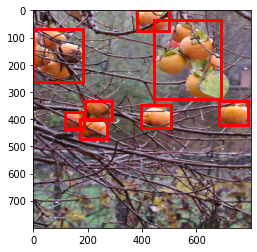

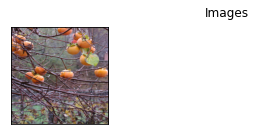

In [141]:

# dataset = prepareData(TEST_PURPOSE)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)
# RPNmodel = RPN()
# DetectionModel = DetectionNetwork()

# all_params = list(list(RPNmodel.parameters()) + list(DetectionModel.parameters()))
# optimizer = torch.optim.Adam(all_params, lr=0.0015)

trained_RPN_model, trained_detectionModel = train_model(faster_rcnn_fe_extractor, optimizer, 3, RPNmodel, data_loader, DetectionModel)
print(trained_RPN_model)
validate(trained_RPN_model, data_loader, faster_rcnn_fe_extractor, trained_detectionModel)

In [111]:
epoch = 0
# rpn_model = torch.load('/content/drive/MyDrive/GMM/rpn_model_%s.pth'%epoch)
model.load_state_dict(torch.load('/content/drive/MyDrive/GMM/rpn_model_%s.pth'%epoch))
model.eval()

validate(rpn_model, data_loader, faster_rcnn_fe_extractor)

RuntimeError: ignored

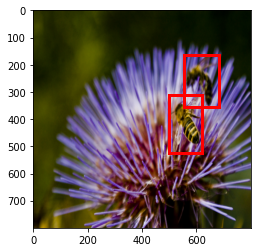

In [149]:
item = dataset.__getitem__(5)
image = item["image"]
image = image.squeeze(0)
boxes = item["boxes"]
show_corner_bbs(image, boxes)